[*********************100%%**********************]  1 of 1 completed
C:\Users\lilya\AppData\Local\Temp\ipykernel_21192\2009798941.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataY.append(target[i + time_step])


ARIMA Mean Squared Error: 20206.326335601905
Random Forest Mean Squared Error: 1614.0178498520154
Gradient Boosting Mean Squared Error: 2191.650013059421
Support Vector Machine (SVM) Mean Squared Error: 6107.263771665373


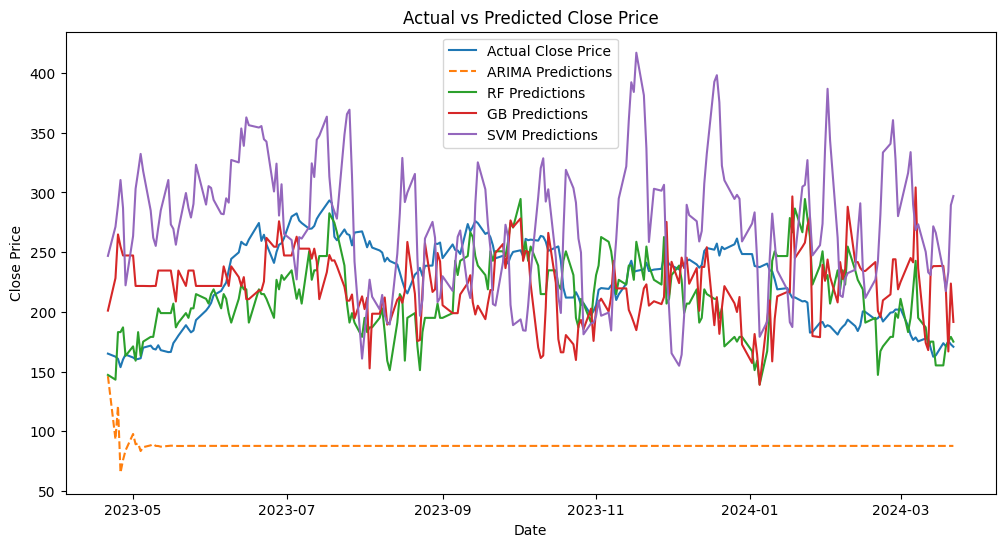

In [21]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365 * 5)
stock_data = yf.download('TSLA', start=start_date.date(), end=end_date.date())


# Use only the 'Close' column
data = pd.DataFrame(stock_data[['Open', 'Close', 'High', 'Low']].values, columns=['Open', 'Close', 'High', 'Low'])
data = pd.DataFrame(stock_data['Close'])


# Define the target variable
data['Signal'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

# Normalize only the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(data[['Close']])

# Define function to create dataset for supervised learning
def create_dataset(dataset, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

# Define time step and split data
time_step = 100
X, y = create_dataset(scaled_close, data['Signal'], time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ARIMA Model
arima_model = ARIMA(y_train, order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(X_test))

# Reshape input for Random Forest and Gradient Boosting
X_train_rf_gb = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test_rf_gb = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf_gb, y_train)
rf_predictions = rf_model.predict(X_test_rf_gb)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_rf_gb, y_train)
gb_predictions = gb_model.predict(X_test_rf_gb)

# Support Vector Machine (SVM)
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_rf_gb, y_train)
svm_predictions = svm_model.predict(X_test_rf_gb)

# Inverse transform predictions for all models
arima_predictions_inv = scaler.inverse_transform(arima_predictions.reshape(-1, 1)).flatten()
rf_predictions_inv = scaler.inverse_transform(rf_predictions.reshape(-1, 1)).flatten()
gb_predictions_inv = scaler.inverse_transform(gb_predictions.reshape(-1, 1)).flatten()
svm_predictions_inv = scaler.inverse_transform(svm_predictions.reshape(-1, 1)).flatten()

# Calculate mean squared error for all models
arima_mse = mean_squared_error(data['Close'][-len(arima_predictions_inv):], arima_predictions_inv)
rf_mse = mean_squared_error(data['Close'][-len(rf_predictions_inv):], rf_predictions_inv)
gb_mse = mean_squared_error(data['Close'][-len(gb_predictions_inv):], gb_predictions_inv)
svm_mse = mean_squared_error(data['Close'][-len(svm_predictions_inv):], svm_predictions_inv)

# Print mean squared error for all models
print("ARIMA Mean Squared Error:", arima_mse)
print("Random Forest Mean Squared Error:", rf_mse)
print("Gradient Boosting Mean Squared Error:", gb_mse)
print("Support Vector Machine (SVM) Mean Squared Error:", svm_mse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(X_test):], data['Close'][-len(X_test):], label='Actual Close Price')
plt.plot(data.index[-len(arima_predictions_inv):], arima_predictions_inv, label='ARIMA Predictions', linestyle='dashed')
plt.plot(data.index[-len(rf_predictions_inv):], rf_predictions_inv, label='RF Predictions')
plt.plot(data.index[-len(gb_predictions_inv):], gb_predictions_inv, label='GB Predictions')
plt.plot(data.index[-len(svm_predictions_inv):], svm_predictions_inv, label='SVM Predictions')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()